In [187]:
import numpy as np
import tensorflow as tf
import pandas as pd
import math
import keras
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
tf.random.set_seed(1)
dataset_path="D:\Tu\ML\Diterpene\convertcsv.xlsx"
test1_path="D:\Tu\ML\Diterpene\diterpene_val1.csv"
test2_path="D:\Tu\ML\Diterpene\diterpene_val2.csv"
multiplicities=["s","d","t","q"]
data=pd.read_excel(dataset_path)
test_data1=pd.read_csv(test1_path)
test_data2=pd.read_csv(test2_path)
test_data2=test_data2.iloc[:,5:]
test_data1=test_data1.iloc[:,5:]
labels=data["a45c"].to_numpy()
freq_Max=230
data = data.drop(["a0","a1","a2","a3","a4","a45c"], axis=1)
data_np =data.to_numpy()
mult_encoder = LabelEncoder()
mult_encoder=mult_encoder.fit(multiplicities)

frequency_encoder = LabelEncoder()
frequency_encoder=frequency_encoder.fit(np.arange(0, freq_Max, 1, dtype=int))

def multiplicityToInt(m,oneHot=False):
    if(oneHot):
        return []
    if m in multiplicities:
         return (multiplicities.index(m)+1)
    raise("Unknown Multiplicitiy Value") 
#turns each row into a function where x is frequency and y is multiplicity from 0 to 230
def convertToXY(datapoint,round_to_int=False,get_raw_mult=False):
    x=np.arange(0. , freq_Max, 0.1)
    x=np.around(x,decimals=2)
    x_final=[]
    y_values=[]
    y_label=[]
    y_full=[]
    for i in range( 0,len(datapoint)-1,2):
        y_values.append(datapoint[i+1])
        y_label.append(datapoint[i])
    if(round_to_int):
        y_values = np.rint(y_values)
    else:
        y_values = np.around(y_values, decimals=1)
    for peak in y_values:
        point_label=y_label[np.where(y_values==peak)[0][0]]
        if not get_raw_mult:
            multiplicity=multiplicityToInt(point_label)
            y_full.append(multiplicity)
        else:
            y_full.append(point_label)
        x_final.append(peak)
        if(round_to_int):
            x_final = [round(x) for x in x_final]
    return (x_final,y_full)
def preprocess(data,sample_size):#Basically Bag of Words
    columns = {str(i): [] for i in range(0, sample_size)}
    rs_data = pd.DataFrame(columns)
    for data_point in data_np:
        testx,testy=convertToXY(data_point,round_to_int=True,get_raw_mult=False)
        new_row =np.zeros(sample_size)
        for ind,x in enumerate(testx):
            new_row[x]+=testy[ind]
        rs_data.loc[len(rs_data)] = new_row
    return rs_data
#Bag of Words with a lower number of features summing all within the frequency interval
def preprocess_bucket(data,number_of_freq,sample_size):
    run_length=math.ceil(number_of_freq/sample_size)
   # print("Run Length: "+str(run_length))
    columns = {str(i): [] for i in range(0, sample_size)}
    rs_data = pd.DataFrame(columns)
    for data_point in data_np:
        testx,testy=convertToXY(data_point,round_to_int=True,get_raw_mult=False)
        new_row =np.zeros(sample_size)
        #iterare over bins
        for index in range(1,sample_size):
            upper_bound=index*run_length
            lower_bound=upper_bound-run_length
         
            for ind,x in enumerate(testx):      
                if(upper_bound>x and x >=lower_bound):
                   # print("found value: " + str(x) + " at bounds: " + str(lower_bound) + ", " + str(upper_bound) + " at index: " + str(index))
                    new_row[index]+=testy[ind]
        rs_data.loc[len(rs_data)] = new_row
       #print("Row Completed: "+str(nrofv))
    return rs_data
            

In [261]:

from sklearn.preprocessing import MinMaxScaler
def grid_search(scale_control):
    early_stopping =  EarlyStopping(
    monitor='val_accuracy', 
    patience=2, 
    min_delta=0.02, 
    mode='max'
    )
    feats=[]
    accs=[]
    highest_acc_number=0
    best_feat_number=0
    for   number_of_features in range(15,200,5):
        reshaped_data=preprocess_bucket(data,231,number_of_features)

        
        X_train, X_test, y_train,y_test = train_test_split(reshaped_data, onehot_encoded_y,
                                                           test_size=0.2, random_state=123)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=123)
        model = Sequential()
        model.add(Dense(round(number_of_features*(2-scale_control), activation='relu', input_shape=(number_of_features,)))
        model.add(Dense(number_of_features*(3-scale_control), activation='relu'))
        model.add(Dense(round(number_of_features), activation='relu'))
        model.add(Dense(22, activation='sigmoid'))
        model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
        model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_val, y_val),
                  verbose=False )

        _, accuracy = model.evaluate(X_test, y_test,verbose=False)
        print("Number of Features: "+ str(number_of_features)+" Test Accuracy: "+ str(accuracy))
        feats.append(number_of_features)
        accs.append(accuracy)
        if (accuracy>highest_acc_number):
              best_feat_number=number_of_features
    print(best_feat_number)
        
        
    return (feats,accs)
              

In [262]:
f,a=grid_search(0)

Number of Features: 15 Test Accuracy: 0.59375
Number of Features: 20 Test Accuracy: 0.6510416865348816
Number of Features: 25 Test Accuracy: 0.7395833134651184
Number of Features: 30 Test Accuracy: 0.734375
Number of Features: 35 Test Accuracy: 0.7708333134651184
Number of Features: 40 Test Accuracy: 0.7864583134651184
Number of Features: 45 Test Accuracy: 0.8020833134651184
Number of Features: 50 Test Accuracy: 0.84375
Number of Features: 55 Test Accuracy: 0.8385416865348816
Number of Features: 60 Test Accuracy: 0.8177083134651184
Number of Features: 65 Test Accuracy: 0.8229166865348816
Number of Features: 70 Test Accuracy: 0.7916666865348816
Number of Features: 75 Test Accuracy: 0.7916666865348816
Number of Features: 80 Test Accuracy: 0.8333333134651184
Number of Features: 85 Test Accuracy: 0.8541666865348816
Number of Features: 90 Test Accuracy: 0.828125
Number of Features: 95 Test Accuracy: 0.875
Number of Features: 100 Test Accuracy: 0.84375
Number of Features: 105 Test Accuracy: 

In [267]:
f2,a2=grid_search(0.5)# smaller nn

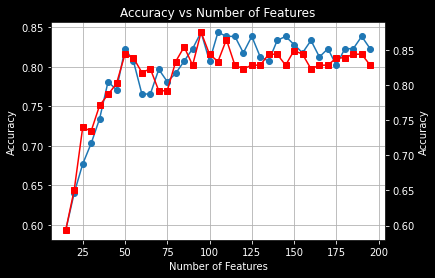

In [272]:

plt.plot(f2, a2, marker='o')
plt.xlabel("Number of Features", color="white")
plt.ylabel("Accuracy", color="white")
plt.title("Accuracy vs Number of Features", color="white")
plt.grid(True)
plt.tick_params(axis="x", colors="white")
plt.tick_params(axis="y", colors="white")

plt.gca().spines["bottom"].set_color("white")
plt.gca().spines["top"].set_color("white")
plt.gca().spines["left"].set_color("white")
plt.gca().spines["right"].set_color("white")

plt.gcf().set_facecolor("black")
ax2 = plt.twinx()
ax2.plot(f, a, marker='s', color='red')
ax2.set_ylabel("Accuracy", color="white")
ax2.tick_params(axis='y', colors='white')
plt.show()

In [276]:
#This time train on the entire training Data on the best numer of features
label_enc=LabelEncoder()
label_enc=label_enc.fit(labels)
y=label_enc.transform(labels)
onehot_encoder = OneHotEncoder(categories='auto', sparse=False)
onehot_encoded_y = onehot_encoder.fit_transform(y.reshape(-1,1)) 
 
number_of_features=100
reshaped_data=preprocess_bucket(data,231,number_of_features)
test_data1=preprocess_bucket(test_data1,231,number_of_features)
test_data2=preprocess_bucket(test_data2,231,number_of_features)
#This time we dont need a seperate test set
X_train, X_val, y_train,y_val = train_test_split(reshaped_data, onehot_encoded_y,test_size=0.2,
                                                 random_state=1)
#X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=123)
 
model = Sequential()
model.add(Dense(round(number_of_features*2), activation='relu', input_shape=(number_of_features,)))
model.add(Dense(number_of_features*3, activation='relu'))
model.add(Dense(round(number_of_features), activation='relu'))
model.add(Dense(22, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=8, batch_size=8, validation_data=(X_val, y_val),
                  verbose=True)


Epoch 1/8
121/121 [==============================] - 1s 2ms/step - loss: 0.1251 - accuracy: 0.5193 - val_loss: 0.0730 - val_accuracy: 0.6722
Epoch 2/8
121/121 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 0.7336 - val_loss: 0.0673 - val_accuracy: 0.7137
Epoch 3/8
121/121 [==============================] - 0s 1ms/step - loss: 0.0453 - accuracy: 0.8314 - val_loss: 0.0585 - val_accuracy: 0.7676
Epoch 4/8
121/121 [==============================] - 0s 1ms/step - loss: 0.0330 - accuracy: 0.8876 - val_loss: 0.0602 - val_accuracy: 0.7884
Epoch 5/8
121/121 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9126 - val_loss: 0.0562 - val_accuracy: 0.8091
Epoch 6/8
121/121 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9657 - val_loss: 0.0527 - val_accuracy: 0.8299
Epoch 7/8
121/121 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.9823 - val_loss: 0.0549 - val_accuracy: 0.8340
Epoch 8/8
121

In [297]:
predictions=[]
for prediction in model.predict(test_data1):
    predictions.append(np.argmax(prediction))
predicted_labels=label_enc.inverse_transform(predictions)
df = pd.DataFrame(predicted_labels, columns=['Predictions'])
df.to_csv(r"D:\\Tu\\ML\\Diterpene\test1_prediction.csv", index=False, header=False)

38/38 [==============================] - 0s 701us/step


In [298]:
predictions=[]
for prediction in model.predict(test_data2):
    predictions.append(np.argmax(prediction))
predicted_labels=label_enc.inverse_transform(predictions)
df = pd.DataFrame(predicted_labels, columns=['Predictions'])
df.to_csv(r"D:\\Tu\\ML\\Diterpene\test1_prediction2.csv", index=False, header=False)

38/38 [==============================] - 0s 701us/step
